In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import time

In [3]:
#loading clean dataframe steamspy from disk 
df = pd.read_csv("../data/clean/steamspy_clean.csv")
df.head()  

,appid,name,developer,publisher,positive,negative,total_reviews,review_ratio,price,initialprice,discount,ccu,owners,avg_playtime_hr,med_playtime_hr,avg_2weeks_hr,med_2weeks_hr
0,730,Counter-Strike: Global Offensive,Valve,Valve,7642084,1173003,8815087,0.87,0.00,0.00,0,1013936,150000000,552.28,108.78,11.68,5.03
1,1172470,Apex Legends,Respawn,Electronic Arts,668053,326926,994979,0.67,0.00,0.00,0,124262,150000000,162.63,13.68,9.93,4.78
2,578080,PUBG: BATTLEGROUNDS,PUBG Corporation,"KRAFTON, Inc.",1520457,1037487,2557944,0.59,0.00,0.00,0,314682,150000000,399.55,96.67,12.80,5.50
3,1623730,Palworld,Pocketpair,Pocketpair,358266,22443,380709,0.94,29.99,29.99,0,18028,75000000,63.32,36.95,14.92,5.02
4,440,Team Fortress 2,Valve,Valve,1044264,117208,1161472,0.90,0.00,0.00,0,43819,75000000,361.90,71.07,10.25,1.37


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   appid            1000 non-null   int64  
 1   name             1000 non-null   object 
 2   developer        1000 non-null   object 
 3   publisher        1000 non-null   object 
 4   positive         1000 non-null   int64  
 5   negative         1000 non-null   int64  
 6   total_reviews    1000 non-null   int64  
 7   review_ratio     1000 non-null   float64
 8   price            1000 non-null   float64
 9   initialprice     1000 non-null   float64
 10  discount         1000 non-null   int64  
 11  ccu              1000 non-null   int64  
 12  owners           1000 non-null   int64  
 13  avg_playtime_hr  1000 non-null   float64
 14  med_playtime_hr  1000 non-null   float64
 15  avg_2weeks_hr    1000 non-null   float64
 16  med_2weeks_hr    1000 non-null   float64
dtypes: float64(7), 

<Axes: ylabel='Frequency'>

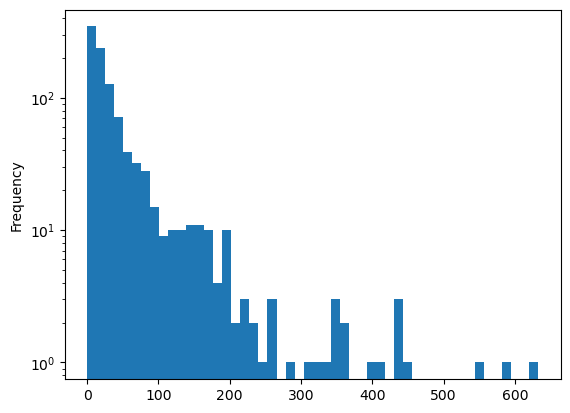

In [8]:
# Distribution Analysis average playtime 

df['avg_playtime_hr'].describe()
df['avg_playtime_hr'].plot(kind='hist', bins=50, log=True)


<Axes: ylabel='Frequency'>

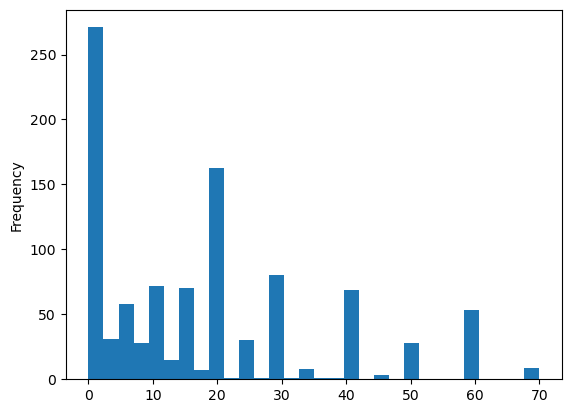

In [9]:
# Distribution Analysis price 
df['price'].describe()
df['price'].plot(kind='hist', bins=30)


In [11]:
#outlier detection 

def iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(series < lower) | (series > upper)]

outliers_playtime = iqr_outliers(df['avg_playtime_hr'])
outliers_playtime[['name','avg_playtime_hr']]


,name,avg_playtime_hr
0,Counter-Strike: Global Offensive,552.28
1,Apex Legends,162.63
2,PUBG: BATTLEGROUNDS,399.55
4,Team Fortress 2,361.90
6,New World: Aeternum,176.48
...,...,...
902,Victoria 3,141.02
961,Secret World Legends,308.37
968,NBA 2K19,168.47
978,The Lab,140.52


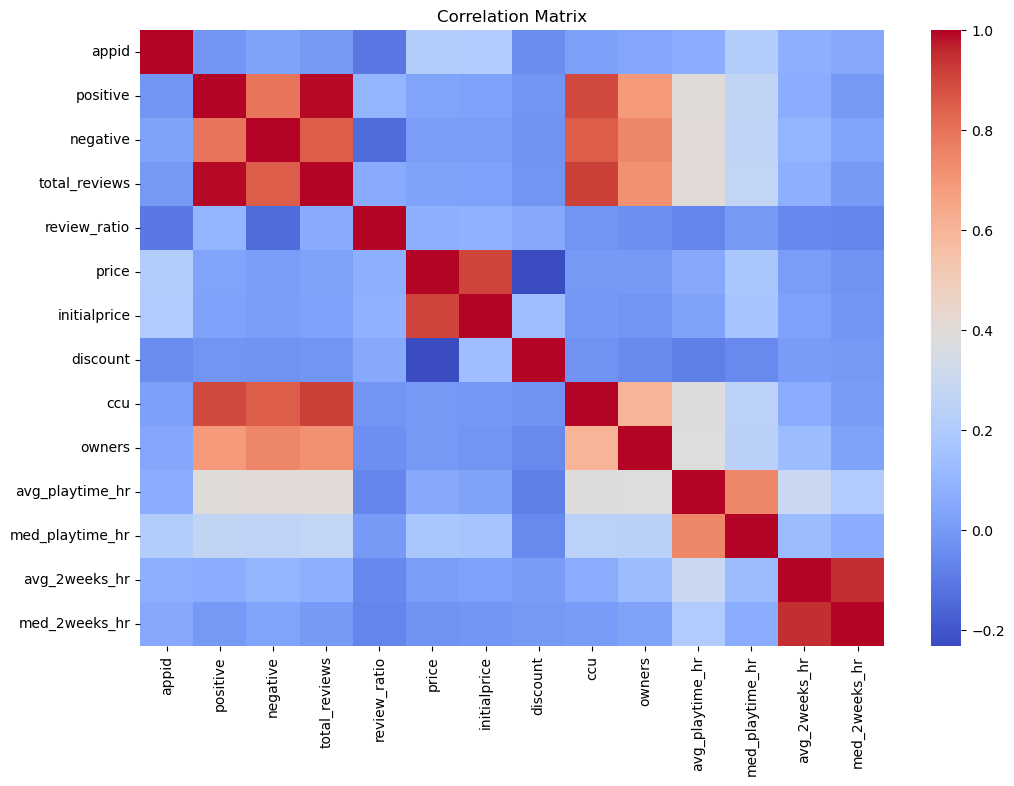

In [12]:
# Correlation Matrix 
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include='number')

plt.figure(figsize=(12,8))
sns.heatmap(numeric_cols.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# Top Games using metrics 

In [13]:
# Most played by average playtime 
df.nlargest(10, 'avg_playtime_hr')[['name','avg_playtime_hr']]


,name,avg_playtime_hr
244,FINAL FANTASY XIV Online,632.35
262,Crosshair X,591.52
0,Counter-Strike: Global Offensive,552.28
505,Football Manager 2023,454.55
492,Football Manager 2021,439.93
189,Football Manager 2020,439.65
460,Football Manager 2022,433.53
357,Cookie Clicker,408.33
2,PUBG: BATTLEGROUNDS,399.55
25,Rust,365.75


In [14]:
# most reviewd games 
df.nlargest(10, 'total_reviews')[['name','total_reviews']]


,name,total_reviews
0,Counter-Strike: Global Offensive,8815087
2,PUBG: BATTLEGROUNDS,2557944
8,Grand Theft Auto V Legacy,1990556
17,Terraria,1409473
24,Tom Clancy's Rainbow Six Siege,1398584
25,Rust,1227784
4,Team Fortress 2,1161472
22,Garry's Mod,1159707
7,Black Myth: Wukong,1150098
16,ELDEN RING,1056677


In [15]:
# Games with the highest concorrent players during the analysis 
df.nlargest(10, 'ccu')[['name','ccu']]


,name,ccu
0,Counter-Strike: Global Offensive,1013936
2,PUBG: BATTLEGROUNDS,314682
479,ELDEN RING NIGHTREIGN,163599
25,Rust,143870
1,Apex Legends,124262
19,Wallpaper Engine,91184
8,Grand Theft Auto V Legacy,67851
5,Call of Duty: Modern Warfare II,67419
49,NARAKA: BLADEPOINT,66954
20,Baldur's Gate 3,54771


In [18]:
# Most Addictive Games KPI and adding a addictiveness_score 

# --- 1. Min-max normalization function ---
def min_max(series):
    return (series - series.min()) / (series.max() - series.min())

# --- 2. Normalize long-term and short-term engagement ---
df["norm_avg_playtime"] = min_max(df["avg_playtime_hr"])
df["norm_avg_2weeks"] = min_max(df["avg_2weeks_hr"])

# --- 3. Compute Addictiveness Score ---
df["addictiveness_score"] = (df["norm_avg_playtime"] + df["norm_avg_2weeks"]) / 2

# --- 4. Sort by Addictiveness Score ---
top_addictive = df.sort_values("addictiveness_score", ascending=False)

# --- 5. Display top 20 addictive games ---
top_20 = top_addictive[["name", "avg_playtime_hr", "avg_2weeks_hr", "addictiveness_score"]].head(20)
print(top_20)


                                       name  avg_playtime_hr  avg_2weeks_hr  \
244                FINAL FANTASY XIV Online           632.35          45.25   
77                         Z1 Battle Royale            65.70         326.02   
262                             Crosshair X           591.52          39.32   
0          Counter-Strike: Global Offensive           552.28          11.68   
505                   Football Manager 2023           454.55          29.40   
357                          Cookie Clicker           408.33          26.40   
492                   Football Manager 2021           439.93           0.27   
189                   Football Manager 2020           439.65           0.00   
460                   Football Manager 2022           433.53           0.12   
677                   Football Manager 2019           349.03          42.67   
2                       PUBG: BATTLEGROUNDS           399.55          12.80   
25                                     Rust         

In [19]:
df.head() 

,appid,name,developer,publisher,positive,negative,total_reviews,review_ratio,price,initialprice,discount,ccu,owners,avg_playtime_hr,med_playtime_hr,avg_2weeks_hr,med_2weeks_hr,norm_avg_playtime,norm_avg_2weeks,addictiveness_score
0,730,Counter-Strike: Global Offensive,Valve,Valve,7642084,1173003,8815087,0.87,0.00,0.00,0,1013936,150000000,552.28,108.78,11.68,5.03,0.873377,0.035826,0.454602
1,1172470,Apex Legends,Respawn,Electronic Arts,668053,326926,994979,0.67,0.00,0.00,0,124262,150000000,162.63,13.68,9.93,4.78,0.257184,0.030458,0.143821
2,578080,PUBG: BATTLEGROUNDS,PUBG Corporation,"KRAFTON, Inc.",1520457,1037487,2557944,0.59,0.00,0.00,0,314682,150000000,399.55,96.67,12.80,5.50,0.631849,0.039261,0.335555
3,1623730,Palworld,Pocketpair,Pocketpair,358266,22443,380709,0.94,29.99,29.99,0,18028,75000000,63.32,36.95,14.92,5.02,0.100134,0.045764,0.072949
4,440,Team Fortress 2,Valve,Valve,1044264,117208,1161472,0.90,0.00,0.00,0,43819,75000000,361.90,71.07,10.25,1.37,0.572310,0.031440,0.301875


In [20]:
#saving new table with kpis 
# df.to_csv("steamspy_with_kpi.csv", index=False)


In [41]:
#loading table with kpi 
df = pd.read_csv("../data/kpis/steamspy_with_kpi.csv")
df.head()  


,appid,name,developer,publisher,positive,negative,total_reviews,review_ratio,price,initialprice,discount,ccu,owners,avg_playtime_hr,med_playtime_hr,avg_2weeks_hr,med_2weeks_hr,norm_avg_playtime,norm_avg_2weeks,addictiveness_score
0,730,Counter-Strike: Global Offensive,Valve,Valve,7642084,1173003,8815087,0.87,0.00,0.00,0,1013936,150000000,552.28,108.78,11.68,5.03,0.873377,0.035826,0.454602
1,1172470,Apex Legends,Respawn,Electronic Arts,668053,326926,994979,0.67,0.00,0.00,0,124262,150000000,162.63,13.68,9.93,4.78,0.257184,0.030458,0.143821
2,578080,PUBG: BATTLEGROUNDS,PUBG Corporation,"KRAFTON, Inc.",1520457,1037487,2557944,0.59,0.00,0.00,0,314682,150000000,399.55,96.67,12.80,5.50,0.631849,0.039261,0.335555
3,1623730,Palworld,Pocketpair,Pocketpair,358266,22443,380709,0.94,29.99,29.99,0,18028,75000000,63.32,36.95,14.92,5.02,0.100134,0.045764,0.072949
4,440,Team Fortress 2,Valve,Valve,1044264,117208,1161472,0.90,0.00,0.00,0,43819,75000000,361.90,71.07,10.25,1.37,0.572310,0.031440,0.301875


In [ ]:
#some visualizations 


In [27]:
# Top 20 Most Addictive Games all time

# Filter for games priced under €20
cheap_games = df[df["price"] < 20]

# Sort by addictiveness score
top_addictive_under_20 = (
    cheap_games.sort_values("addictiveness_score", ascending=False)
               .head(20)
)

# Display results
print(
    top_addictive_under_20[
        ["name", "price", "avg_playtime_hr", "avg_2weeks_hr", "addictiveness_score"]
    ]
)


                                       name  price  avg_playtime_hr  \
244                FINAL FANTASY XIV Online  19.99           632.35   
77                         Z1 Battle Royale   0.00            65.70   
262                             Crosshair X   4.99           591.52   
0          Counter-Strike: Global Offensive   0.00           552.28   
505                   Football Manager 2023   0.00           454.55   
357                          Cookie Clicker   4.99           408.33   
492                   Football Manager 2021   0.00           439.93   
189                   Football Manager 2020   0.00           439.65   
460                   Football Manager 2022   0.00           433.53   
677                   Football Manager 2019   0.00           349.03   
2                       PUBG: BATTLEGROUNDS   0.00           399.55   
4                           Team Fortress 2   0.00           361.90   
342                            Transformice   0.00           140.83   
835   

C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\4273059112.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


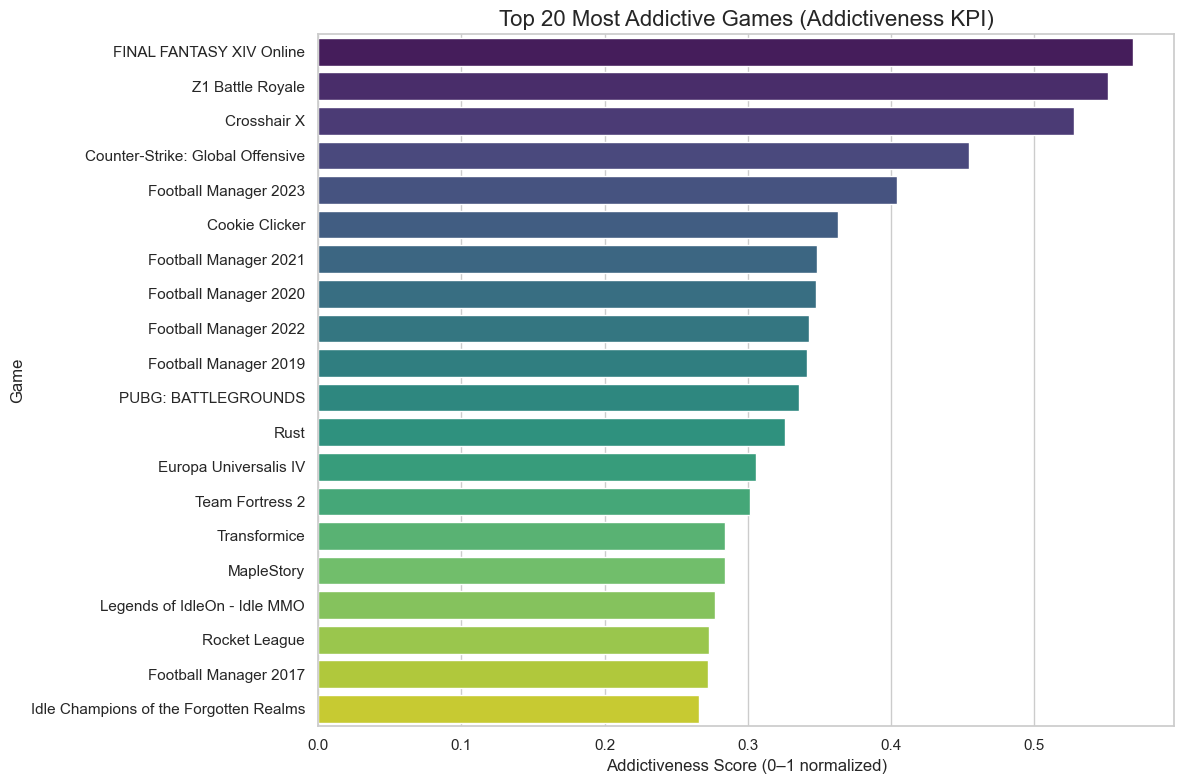

In [21]:
# barchart for Top 20 Most Addictive Games all time 

# Sort by KPI and select top 20
top20 = df.sort_values("addictiveness_score", ascending=False).head(20)

# Set plot style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))

# Horizontal bar chart
sns.barplot(
    data=top20,
    x="addictiveness_score",
    y="name",
    palette="viridis"
)

plt.title("Top 20 Most Addictive Games (Addictiveness KPI)", fontsize=16)
plt.xlabel("Addictiveness Score (0–1 normalized)")
plt.ylabel("Game")
plt.tight_layout()

plt.show()


In [25]:
# Top 20 Most Addictive Games in recently costing under 20 dolares 

# Filter for games priced under €20
cheap_games = df[df["price"] < 20]

# Sort by short-term engagement (avg_2weeks_hr)
top_short_term = (
    cheap_games.sort_values("avg_2weeks_hr", ascending=False)
               .head(20)
)

# Display results
print(
    top_short_term[
        ["name", "price", "avg_2weeks_hr", "avg_playtime_hr", "addictiveness_score"]
    ]
)


                                             name  price  avg_2weeks_hr  \
77                               Z1 Battle Royale   0.00         326.02   
342                                  Transformice   0.00         112.88   
69                                    Black Squad   0.00         109.02   
895                              Tower of Fantasy   0.00          93.73   
835                                    MapleStory   0.00          86.70   
422                      Jurassic World Evolution  11.24          85.43   
683                  Legends of IdleOn - Idle MMO   0.00          78.65   
628  Warhammer 40,000: Chaos Gate - Daemonhunters  11.24          74.83   
697        Idle Champions of the Forgotten Realms   0.00          72.00   
150                                     Crab Game   0.00          70.72   
32                                       PAYDAY 2   4.99          51.07   
771                             Shakes and Fidget   0.00          49.03   
244                      

C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\815506539.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


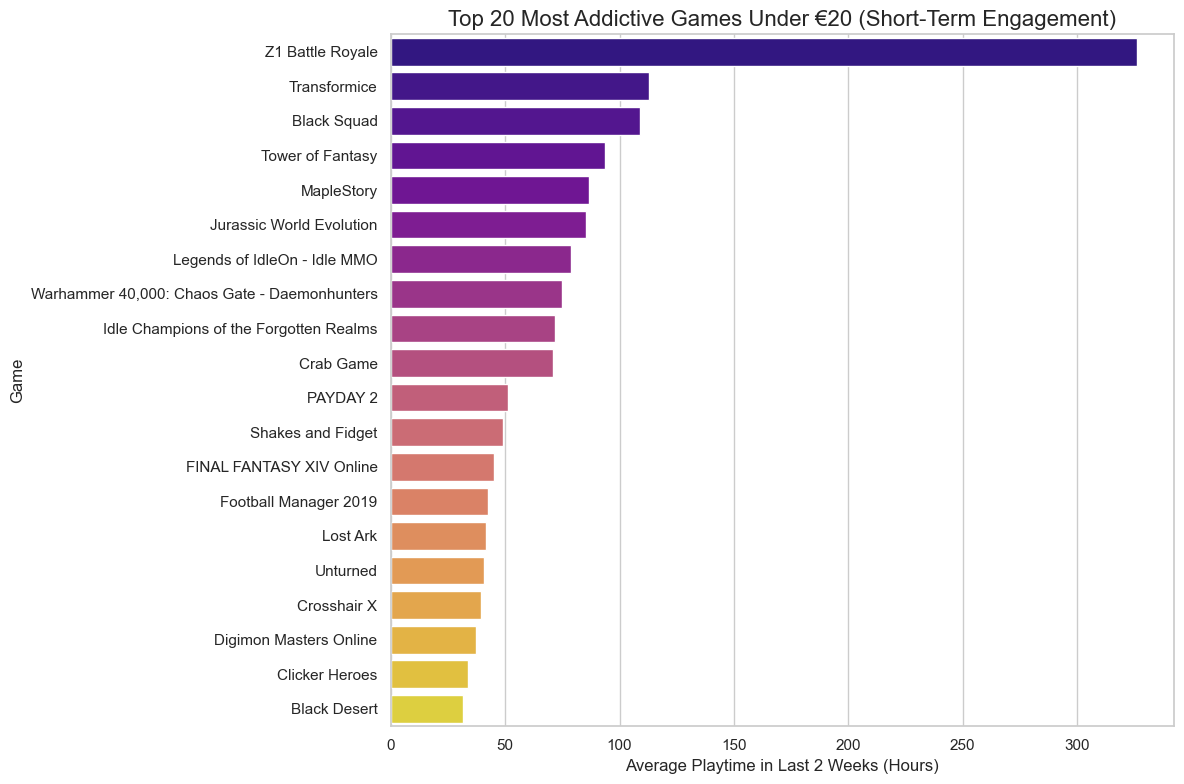

In [26]:
# barchart for Top 20 Most Addictive Games in recently costing under 20 dolares 

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))

sns.barplot(
    data=top_short_term,
    x="avg_2weeks_hr",
    y="name",
    palette="plasma"
)

plt.title("Top 20 Most Addictive Games Under €20 (Short-Term Engagement)", fontsize=16)
plt.xlabel("Average Playtime in Last 2 Weeks (Hours)")
plt.ylabel("Game")
plt.tight_layout()

plt.show()


# Working on Hyphotesis 


In [ ]:
# Hypothesis 1  "Free-to-play games (price = 0) have higher concurrent users than paid games." 

# H₀ Free‑to‑play games (price = 0) have the same average concurrent users (CCU) as paid games. 
# H₁ Free‑to‑play games (price = 0) have higher average concurrent users than paid games. 

In [30]:
# split the dataset between free games (0) and paid (>1) 

# Split into free-to-play and paid
free = df[df["price"] == 0]
paid = df[df["price"] > 0]


In [31]:
Comparing tbe means 
print("Average CCU (Free-to-play):", free["ccu"].mean())
print("Average CCU (Paid):", paid["ccu"].mean())


Average CCU (Free-to-play): 8779.33193277311
Average CCU (Paid): 3451.520997375328


In [32]:
# Statistical welch's t-test 
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(
    free["ccu"],
    paid["ccu"],
    equal_var=False,
    alternative="greater"   # one-sided test
)

print("t-statistic:", t_stat)
print("p-value:", p_value)




t-statistic: 1.178405031684112
p-value: 0.11989921288634371


C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\994420656.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


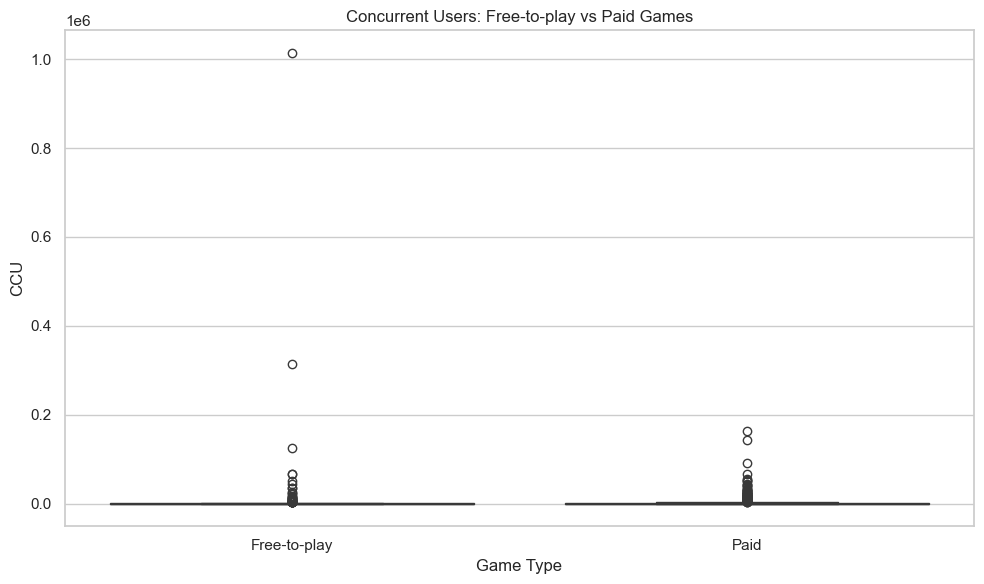

In [33]:
# Boxplot 
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x=(df["price"] == 0).map({True: "Free-to-play", False: "Paid"}),
    y="ccu",
    palette="viridis"
)

plt.title("Concurrent Users: Free-to-play vs Paid Games")
plt.xlabel("Game Type")
plt.ylabel("CCU")
plt.tight_layout()
plt.show()


C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\3021187493.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(free["ccu"], label="Free-to-play", shade=True)
C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\3021187493.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(paid["ccu"], label="Paid", shade=True)


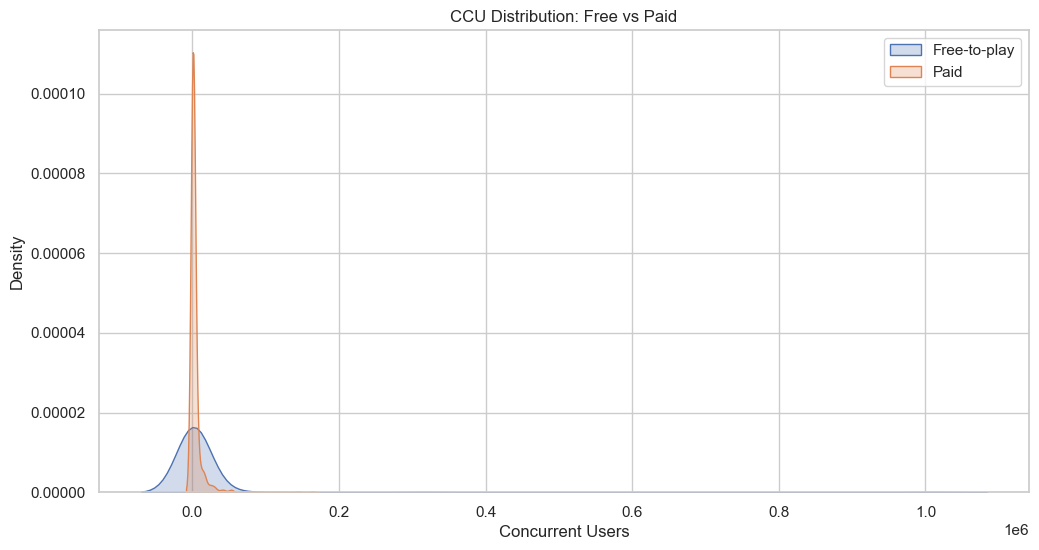

In [34]:
# Distribution Plot

plt.figure(figsize=(12, 6))
sns.kdeplot(free["ccu"], label="Free-to-play", shade=True)
sns.kdeplot(paid["ccu"], label="Paid", shade=True)
plt.title("CCU Distribution: Free vs Paid")
plt.xlabel("Concurrent Users")
plt.legend()
plt.show()


# conclusions
Welch’s t-test results:
t-statistic: 1.178
p-value: 0.1199
The average CCU for free-to-play games is higher than for paid games.
However, the difference is not statistically significant at the 95% confidence level.

I cannot reject the null hypothesis because I don’t have strong enough evidence to claim that free games have higher CCU on average.

Density Plot Insights:
Free-to-play games show a wider spread - some have extremely high CCU, but many are low.


Paid games are tightly clustered near low CCU — fewer outliers, more consistency.
This suggests free games are more volatile — they can go viral, but many don’t.

Free‑to‑play games have higher variance
Paid games are more concentrated
Both distributions are heavily skewed toward low CCU

Conclusion:
While free-to-play games include some of the most played titles on Steam, the overall difference in concurrent users compared to paid games is not statistically significant. The distribution shows greater extremes for free games, but most games, paid or free, have low CCU

Need to go deep in the analysis. 

In [ ]:
#second phase of testing the hyphotesis 
# Of all the people who own the game, how many are playing right now? 

In [35]:
#Need to analyse CCU per game onwnership

# Avoid division by zero
df = df[df["owners"] > 0]

# Create CCU per owner metric
df["ccu_per_owner"] = df["ccu"] / df["owners"]

df[["name", "price", "ccu", "owners", "ccu_per_owner"]].head()





,name,price,ccu,owners,ccu_per_owner
0,Counter-Strike: Global Offensive,0.00,1013936,150000000,0.006760
1,Apex Legends,0.00,124262,150000000,0.000828
2,PUBG: BATTLEGROUNDS,0.00,314682,150000000,0.002098
3,Palworld,29.99,18028,75000000,0.000240
4,Team Fortress 2,0.00,43819,75000000,0.000584


In [ ]:
# added new kpi collunm "ccu_per_owner" to anwser the question: "Of all the people who own the game, how many are playing right now?" 

In [36]:
# Comparing free vs paid games 

free = df[df["price"] == 0]
paid = df[df["price"] > 0]

print("Average CCU per owner (Free):", free["ccu_per_owner"].mean())
print("Average CCU per owner (Paid):", paid["ccu_per_owner"].mean())


Average CCU per owner (Free): 0.0003500049299719888
Average CCU per owner (Paid): 0.0005488463992000999


In [37]:
# Welch’s t‑test

from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(
    free["ccu_per_owner"],
    paid["ccu_per_owner"],
    equal_var=False,
    alternative="greater"   # one-sided: free > paid
)

print("t-statistic:", t_stat)
print("p-value:", p_value)


t-statistic: -2.198346023173552
p-value: 0.9859065583868286


C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\407049397.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


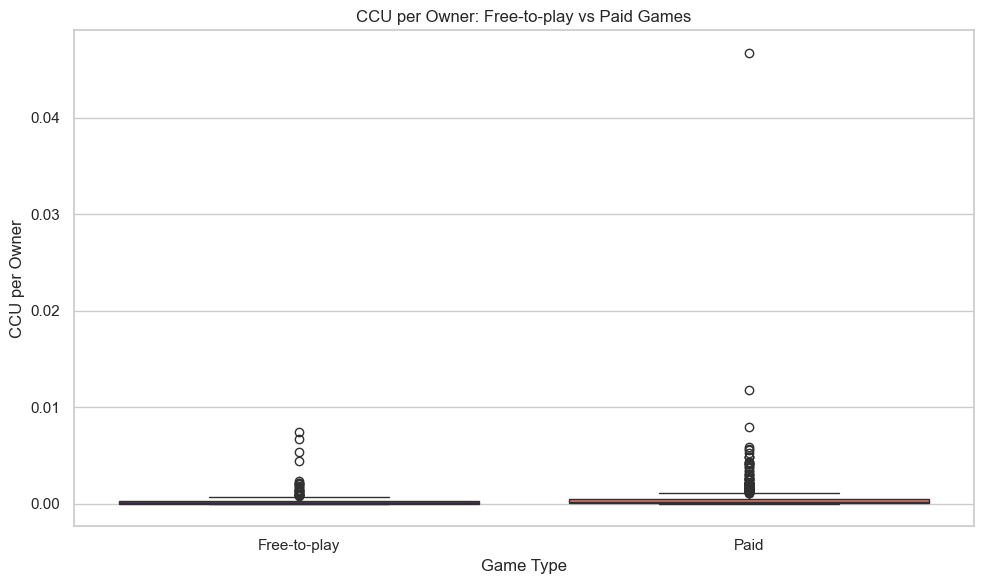

In [38]:
# visualizing the diference in boxplot 
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x=(df["price"] == 0).map({True: "Free-to-play", False: "Paid"}),
    y="ccu_per_owner",
    palette="magma"
)

plt.title("CCU per Owner: Free-to-play vs Paid Games")
plt.xlabel("Game Type")
plt.ylabel("CCU per Owner")
plt.tight_layout()
plt.show()


C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\2583925353.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(free["ccu_per_owner"], label="Free-to-play", shade=True)
C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\2583925353.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(paid["ccu_per_owner"], label="Paid", shade=True)


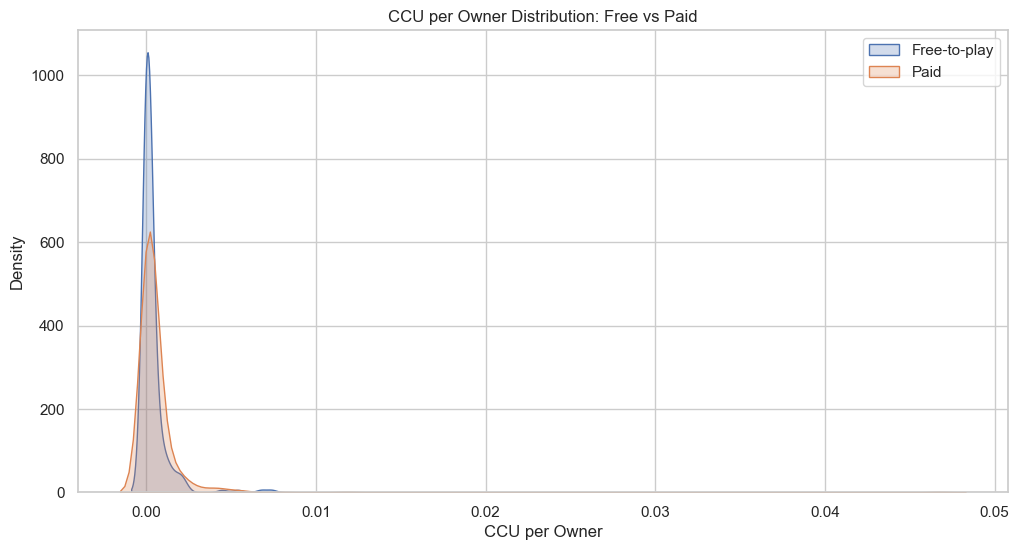

In [39]:
plt.figure(figsize=(12, 6))
sns.kdeplot(free["ccu_per_owner"], label="Free-to-play", shade=True)
sns.kdeplot(paid["ccu_per_owner"], label="Paid", shade=True)
plt.title("CCU per Owner Distribution: Free vs Paid")
plt.xlabel("CCU per Owner")
plt.legend()
plt.show()


# conclusions
No things get more interesting. 
Free-to-play: 0.0003500
Paid: 0.0005488

Paid games have higher CCU per owner than free games. This means:
- That paid players are more likely to be actively playing the games they own
- Free-to-play games attract huge audiences, but a smaller fraction of those players are active at any given moment
- Paid games have more loyal or committed players relative to their owner base

We can see that free to play games have massive download numbers. But many players try the game once and never return. 
There is a wide engagement, but shallow. 

Concerning to paid games, there is a smaller onwer base (because they need to pay the games), but players that pay for the games are more invested. In this case, the engagement is narrow comparing to free-to-play, but deep. 

Free games often dominate raw CCU, paid games win on engagement intensity. 

Looking to my original hypotheis, "Free-to-play games have higher concurrent users than paid games"

After normalization: 
Raw CCU: free games look bigger
CCU per owner: paid games are more engaged

overall conclusion: 

t‑statistic = –2.198
p‑value = 0.9859  - this is almost 1.0 

The data strongly contradicts my hypothesis. 
There is no statistical support for “free > paid”.
The evidence points in the opposite direction

-- Free games attract more players overall, but paid games retain a higher percentage of their owners -- 
-- Players who buy a game are more likely to still be playing it. -- 
-- Free games attracts huge numbers of owners, but only a small fraction stay active -- 


C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\609045346.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


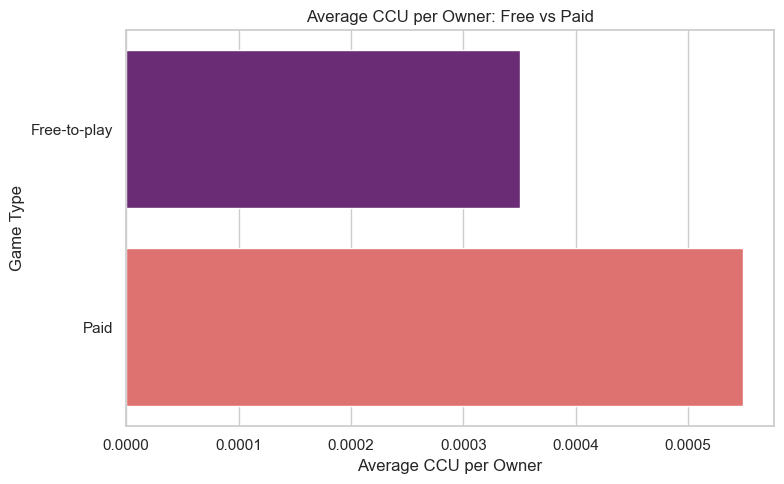

In [46]:
# Bar Chart: Average CCU per Owner 

avg_values = df.groupby(
    (df["price"] == 0).map({True: "Free-to-play", False: "Paid"})
)["ccu_per_owner"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=avg_values,
    x="ccu_per_owner",
    y="price",
    palette="magma"
)

plt.title("Average CCU per Owner: Free vs Paid")
plt.xlabel("Average CCU per Owner")
plt.ylabel("Game Type")
plt.tight_layout()
plt.show()


In [ ]:
# We can see that Paid games are clearly higher than free to play games. 

In [ ]:
#third phase of testing the hyphotesis 
# Need to compare CCU per owner across different price tiers. This avoids the binnary stigma (paid vs free). 
# this will test if whether engagement intensity changes with price. 


# Creating price tiers (bins) 
Free
0.99–4.99
5–19.99
20–39.99
40+

In [51]:
# Avoid division by zero
df = df[df["owners"] > 0]

# CCU per owner
df["ccu_per_owner"] = df["ccu"] / df["owners"]

# Define price tiers
bins = [-0.01, 0, 4.99, 19.99, 39.99, df["price"].max()]
labels = ["Free", "0.99–4.99", "5–19.99", "20–39.99", "40+"]

df["price_tier"] = pd.cut(df["price"], bins=bins, labels=labels)



In [52]:
tier_summary = (
    df.groupby("price_tier")["ccu_per_owner"]
      .mean()
      .sort_index()
)

print(tier_summary)


price_tier
Free         0.000350
0.99–4.99    0.000455
5–19.99      0.000312
20–39.99     0.000827
40+          0.001023
Name: ccu_per_owner, dtype: float64


C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\10694781.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("price_tier")["ccu_per_owner"]


C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\4236056563.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


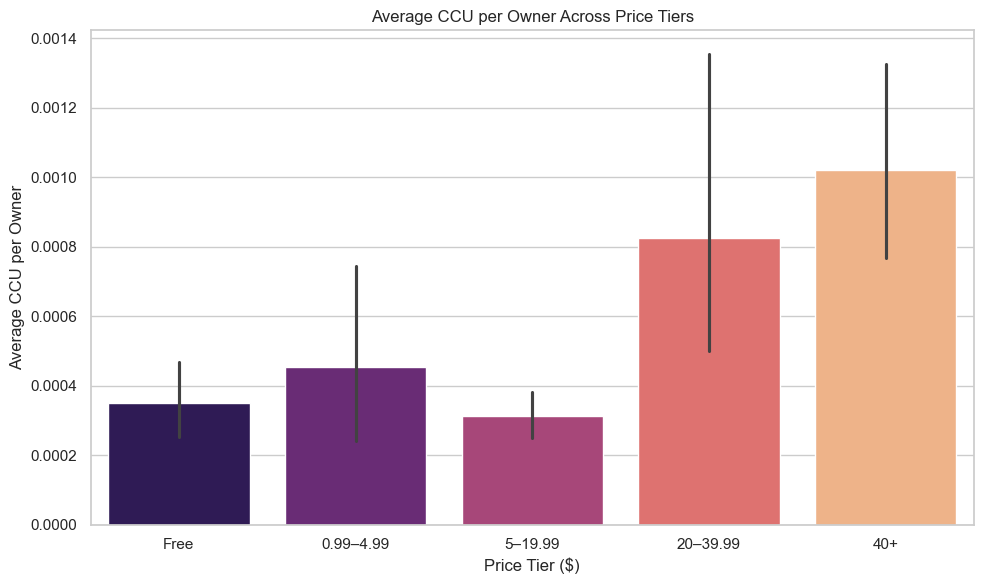

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x="price_tier",
    y="ccu_per_owner",
    estimator="mean",
    palette="magma"
)

plt.title("Average CCU per Owner Across Price Tiers")
plt.xlabel("Price Tier ($)")
plt.ylabel("Average CCU per Owner")
plt.tight_layout()
plt.show()


# conclusions 

1 - Free games have the lowest engagement intensity. Despite massive player bases, only a small fraction of owners are actively playing at any given time.
2 - There is a surprise dip on tier 5-19,99, as this tier has the lowest CCU per owner among paid games. This price tier can be related to possible impulse buys or casual titles with short lifespans.
3 - The games with the price above 20 dollars have more active players per owner. 
We can conclude by this that players are more invested. Normally this games AA and AAA offers deeper or longer experiences. 
Communities are more persistent in this games. 

Strategic Takeaways
- Price is a strong predictor of engagement intensity
- Free games attract, but paid games retain
- Mid‑price games may need better retention strategies
- High‑price games justify their cost with deeper engagement


In [ ]:
# next steps - identify outliers 

In [57]:
# Identify Outliers Using the IQR Method

import numpy as np

# Compute IQR
Q1 = df["ccu_per_owner"].quantile(0.25)
Q3 = df["ccu_per_owner"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df["ccu_per_owner"] < lower_bound) | (df["ccu_per_owner"] > upper_bound)]

outliers[["name", "price", "ccu", "owners", "ccu_per_owner"]].head()




,name,price,ccu,owners,ccu_per_owner
0,Counter-Strike: Global Offensive,0.00,1013936,150000000,0.006760
2,PUBG: BATTLEGROUNDS,0.00,314682,150000000,0.002098
12,War Thunder,0.00,50478,35000000,0.001442
14,HELLDIVERS 2,39.99,53399,35000000,0.001526
19,Wallpaper Engine,4.99,91184,35000000,0.002605


In [58]:
# Separate Outliers by Free vs Paid 
free_outliers = outliers[outliers["price"] == 0]
paid_outliers = outliers[outliers["price"] > 0]

print("Free-to-play outliers:", len(free_outliers))
print("Paid outliers:", len(paid_outliers))


Free-to-play outliers: 20
Paid outliers: 93


C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\753482743.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


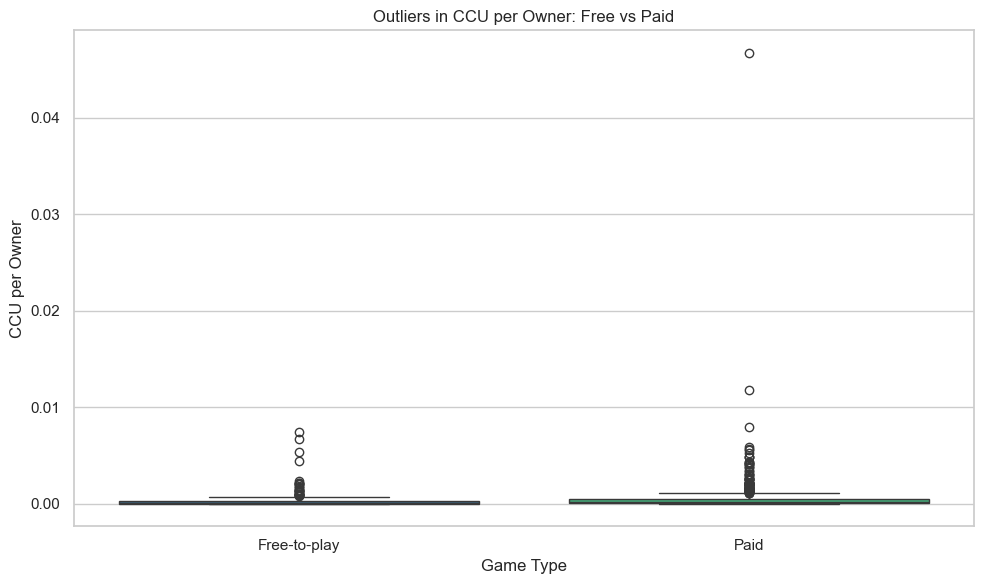

In [59]:
# Outliers on a Boxplot 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x=(df["price"] == 0).map({True: "Free-to-play", False: "Paid"}),
    y="ccu_per_owner",
    showfliers=True,   # show outliers
    palette="viridis"
)

plt.title("Outliers in CCU per Owner: Free vs Paid")
plt.xlabel("Game Type")
plt.ylabel("CCU per Owner")
plt.tight_layout()
plt.show()


In [60]:
# Identify the Top Outliers - high engagement 

top_outliers = df[df["ccu_per_owner"] > upper_bound].sort_values("ccu_per_owner", ascending=False)

top_outliers[["name", "price", "ccu_per_owner"]].head(10)


,name,price,ccu_per_owner
479,ELDEN RING NIGHTREIGN,39.99,0.046743
262,Crosshair X,4.99,0.011837
305,Clair Obscur: Expedition 33,49.99,0.007966
683,Legends of IdleOn - Idle MMO,0.00,0.007387
0,Counter-Strike: Global Offensive,0.00,0.006760
832,Diablo IV,49.99,0.005890
244,FINAL FANTASY XIV Online,19.99,0.005664
202,EA SPORTS FC 25,69.99,0.005604
835,MapleStory,0.00,0.005395
208,Grand Theft Auto V Enhanced,29.99,0.005267


In [65]:
# Detect High Outliers (IQR Method) 

Q1 = df["ccu_per_owner"].quantile(0.25)
Q3 = df["ccu_per_owner"].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

high_outliers = df[df["ccu_per_owner"] > upper_bound]


In [66]:
# Select the Top 10 High‑Engagement Outliers 
top10 = (
    high_outliers
    .sort_values("ccu_per_owner", ascending=False)
    .head(10)
)


C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\2854077653.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


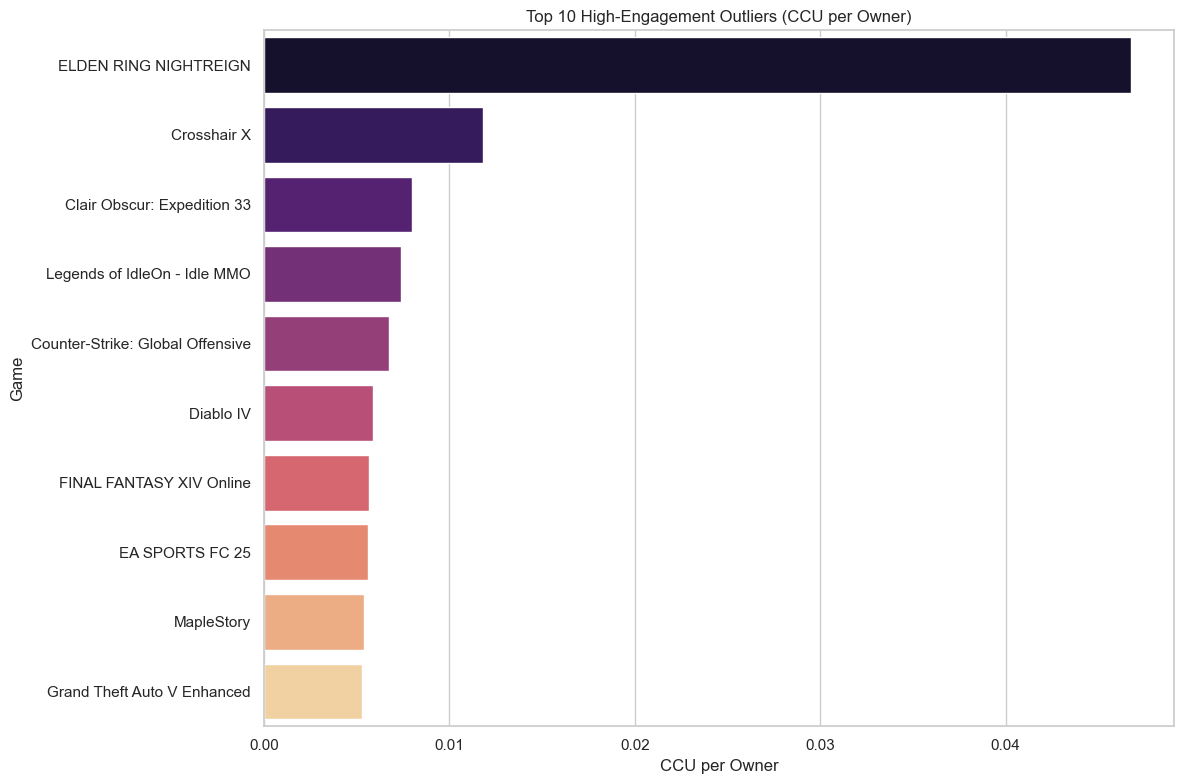

In [67]:
# visualization for the top 10 outliers and most engagement. 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

sns.barplot(
    data=top10,
    x="ccu_per_owner",
    y="name",
    palette="magma"
)

plt.title("Top 10 High-Engagement Outliers (CCU per Owner)")
plt.xlabel("CCU per Owner")
plt.ylabel("Game")
plt.tight_layout()
plt.show()



A clear ranking of the 10 most loyal communities on Steam
A visual sense of how extreme these outliers are



C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\1590550876.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\1590550876.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


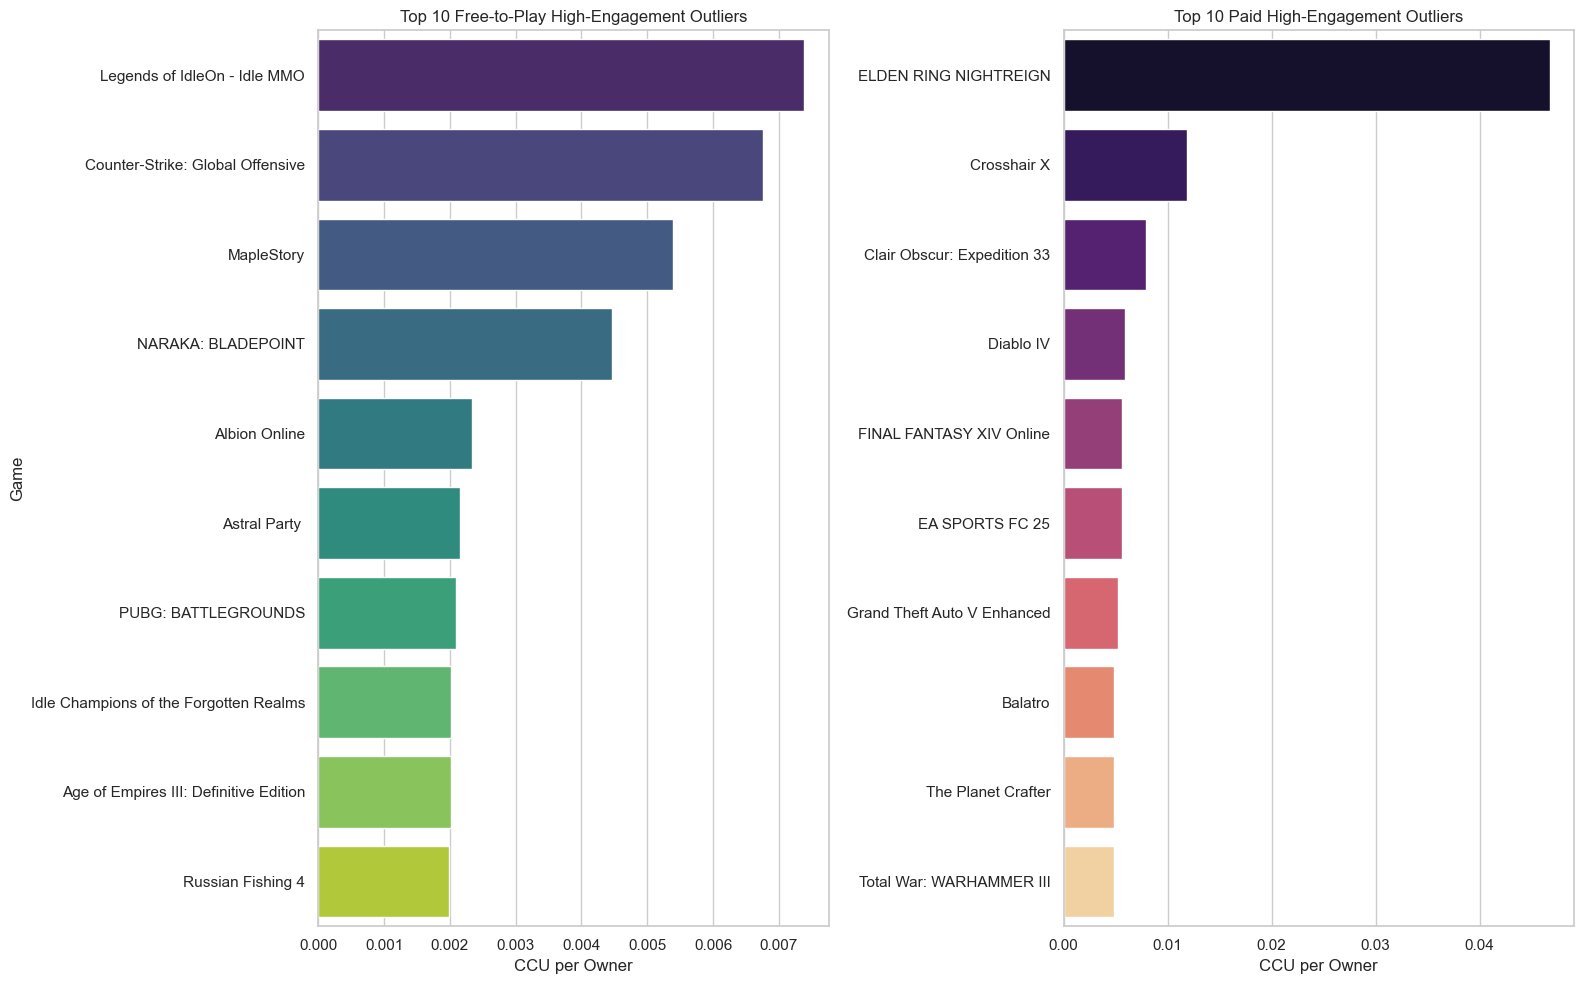

In [68]:

# Side‑by‑Side Plot for Free vs Paid High‑Engagement Outliers 

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Detect high outliers using IQR
Q1 = df["ccu_per_owner"].quantile(0.25)
Q3 = df["ccu_per_owner"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

high_outliers = df[df["ccu_per_owner"] > upper_bound]

# 2. Split into free vs paid
free_outliers = high_outliers[high_outliers["price"] == 0]
paid_outliers = high_outliers[high_outliers["price"] > 0]

# 3. Select top 10 from each
top10_free = free_outliers.sort_values("ccu_per_owner", ascending=False).head(10)
top10_paid = paid_outliers.sort_values("ccu_per_owner", ascending=False).head(10)

# 4. Side-by-side visualization
plt.figure(figsize=(16, 10))

# Left plot: Free outliers
plt.subplot(1, 2, 1)
sns.barplot(
    data=top10_free,
    x="ccu_per_owner",
    y="name",
    palette="viridis"
)
plt.title("Top 10 Free-to-Play High-Engagement Outliers")
plt.xlabel("CCU per Owner")
plt.ylabel("Game")

# Right plot: Paid outliers
plt.subplot(1, 2, 2)
sns.barplot(
    data=top10_paid,
    x="ccu_per_owner",
    y="name",
    palette="magma"
)
plt.title("Top 10 Paid High-Engagement Outliers")
plt.xlabel("CCU per Owner")
plt.ylabel("")

plt.tight_layout()
plt.show()


A direct comparison of the most extreme free vs paid games
A clear sense of which group dominates high engagement
A way to spot genre‑like patterns even without genre data

C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\3657471339.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_outliers["game_type"] = high_outliers["price"].apply(lambda x: "Free-to-play" if x == 0 else "Paid")
C:\Users\ptpsy\AppData\Local\Temp\ipykernel_10256\3657471339.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


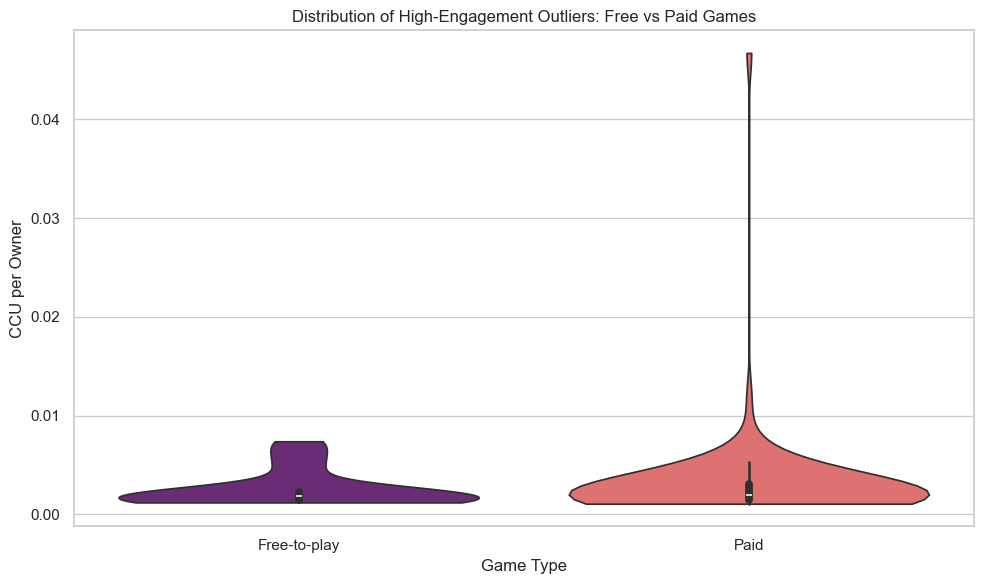

In [69]:
# Violin Plot for Free vs Paid High‑Engagement Outliers 

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Detect high outliers using IQR
Q1 = df["ccu_per_owner"].quantile(0.25)
Q3 = df["ccu_per_owner"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

high_outliers = df[df["ccu_per_owner"] > upper_bound]

# 2. Create a column for game type
high_outliers["game_type"] = high_outliers["price"].apply(lambda x: "Free-to-play" if x == 0 else "Paid")

# 3. Violin plot comparing free vs paid outliers
plt.figure(figsize=(10, 6))

sns.violinplot(
    data=high_outliers,
    x="game_type",
    y="ccu_per_owner",
    palette="magma",
    cut=0
)

plt.title("Distribution of High-Engagement Outliers: Free vs Paid Games")
plt.xlabel("Game Type")
plt.ylabel("CCU per Owner")
plt.tight_layout()
plt.show()


Spread: Are free outliers more volatile than paid ones?

Density: Do paid outliers cluster tightly at high engagement?

Skew: Are free outliers dominated by a few extreme hits?

Paid outliers form a tighter, higher‑engagement cluster

Free outliers show wider spread with a few extreme spikes